In [27]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

# Language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# Language processing with TextBlob
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from collections import Counter

import sys
sys.path.append('../src')

from plot_correlation import plot_corr_mats, plot_metrics_distrib, plot_nlp_metrics, plot_nlp_distrib

%load_ext autoreload
%autoreload 2

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
def spark_to_pandas(spark_metrics):
    metrics_pd = spark_metrics.toPandas()
    metrics_pd = metrics_pd.set_index('creation_date')
    metrics_pd = metrics_pd.sort_index()
    return metrics_pd

In [4]:
def get_metrics(filename, sql_query, sql_table_name):
    spark_metrics = spark.read.load(filename)
    spark_metrics.registerTempTable(sql_table_name)
    avg_metrics = spark.sql(sql_query)

    pd_metrics = spark_to_pandas(spark_metrics)
    pd_metrics_avg = spark_to_pandas(avg_metrics)
    pd_metrics_n = pd_metrics.div(pd_metrics['msg_count'], axis=0)
    pd_metrics_avg_n = pd_metrics_avg.div(pd_metrics_avg['msg_count_60d_avg'], axis=0)
    
    return pd_metrics_n, pd_metrics_avg_n, pd_metrics, pd_metrics_avg

### NLTK Metrics

In [154]:
nltk_full_name = '../data/nlp_nltk_metrics_daily_full_0.01.parquet/'
nltk_15_17_name = '../data/nlp_nltk_metrics_daily_15_17_0.1.parquet/'

nltk_sql_table_name = 'nltk_metrics'
nltk_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nltk_negativity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_negativity_60d_avg,

    AVG(sum_nltk_neutrality) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_neutrality_60d_avg,
    
    AVG(sum_nltk_positivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_positivity_60d_avg

FROM {nltk_sql_table_name}
""")

def plot_nltk_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_averages(neg=True, neu=True, pos=True):
        plt.figure(figsize=(20, 10))
        title = None
        labels = []
        if neg:
            title = 'Negativity avg'
            labels.append('Negativity avg')
            plt.plot(m_avg_n['nltk_negativity_60d_avg'])
        if neu:
            title = 'Neutrality avg' if title is None else title + ' VS Neutrality avg'
            labels.append('Neutrality avg')
            plt.plot(m_avg_n['nltk_neutrality_60d_avg'])
        if pos:
            title = 'Positivity avg' if title is None else title + ' VS Positivity avg'
            labels.append('Positivity avg')
            plt.plot(m_avg_n['nltk_positivity_60d_avg'])
        plt.title(title + ' scores over time')
        plt.xlabel('Date')
        plt.ylabel('Score')
        plt.legend(labels)
    
    def plot_stat(neg=False, neu=False, pos=False):
        if neg or neu or pos:
            plt.figure(figsize=(20, 10))
        if neg:
            plt.plot(m_n['sum_nltk_negativity'])
            plt.plot(m_avg_n['nltk_negativity_60d_avg'])
            plt.title('Negativity scores over time')
            plt.legend(['Negativity', 'Negativity avg'])
        elif neu:
            plt.plot(m_n['sum_nltk_neutrality'])
            plt.plot(m_avg_n['nltk_neutrality_60d_avg'])
            plt.title('Neutrality scores over time')
            plt.legend(['Neutrality', 'Neutrality avg'])
        elif pos:
            plt.plot(m_n['sum_nltk_positivity'])
            plt.plot(m_avg_n['nltk_positivity_60d_avg'])
            plt.title('Positivity scores over time')
            plt.legend(['Positivity', 'Positivity avg'])
        else:
            print('Please set one of the following parameter to True: [neg, neu, pos]')
            return
        
        plt.xlabel('Date')
        plt.ylabel('Score')
            
    return plot_averages, plot_stat

#### NLTK 2005 - 2017

In [155]:
nltk_plot_averages, nltk_plot_stat = plot_nltk_metrics(nltk_full_name, nltk_sql_query, nltk_sql_table_name)

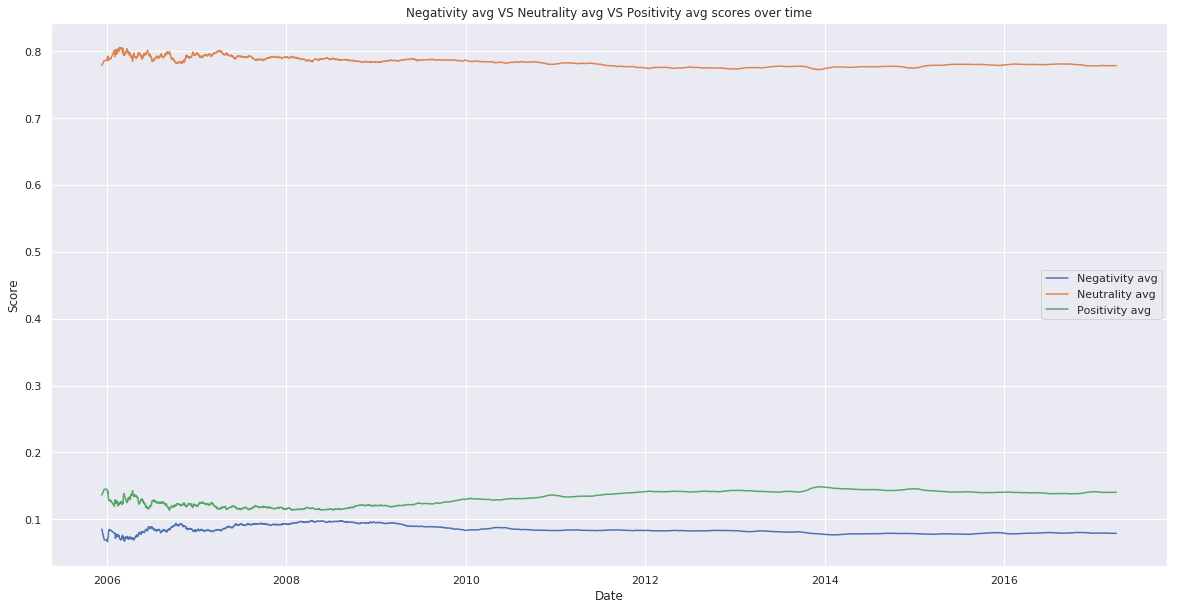

In [156]:
nltk_plot_averages()

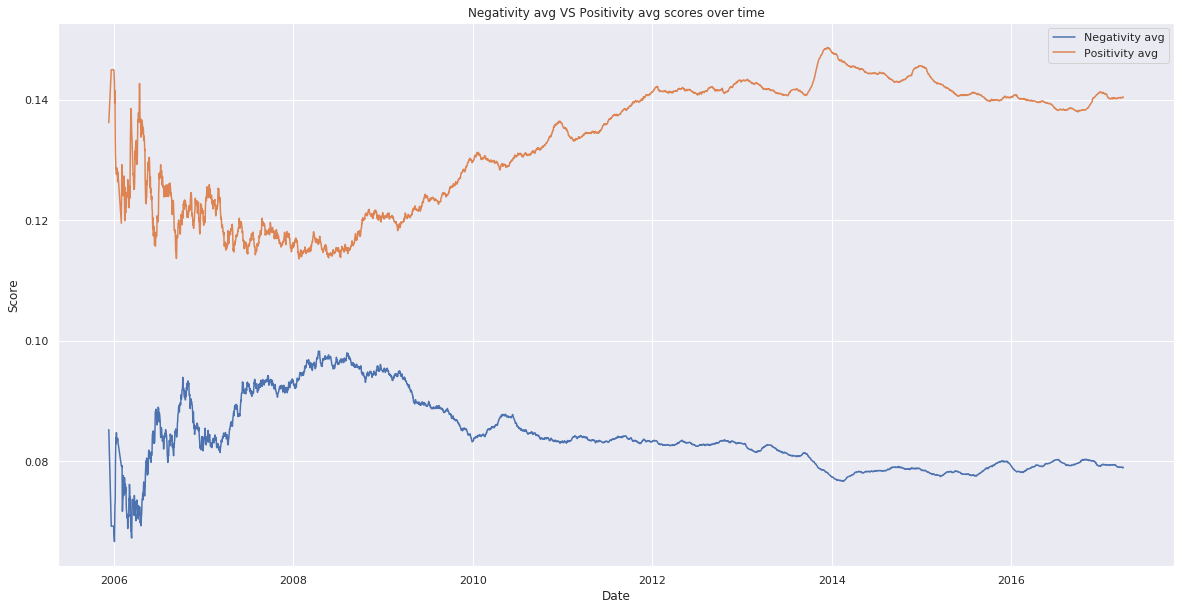

In [157]:
nltk_plot_averages(neu=False)

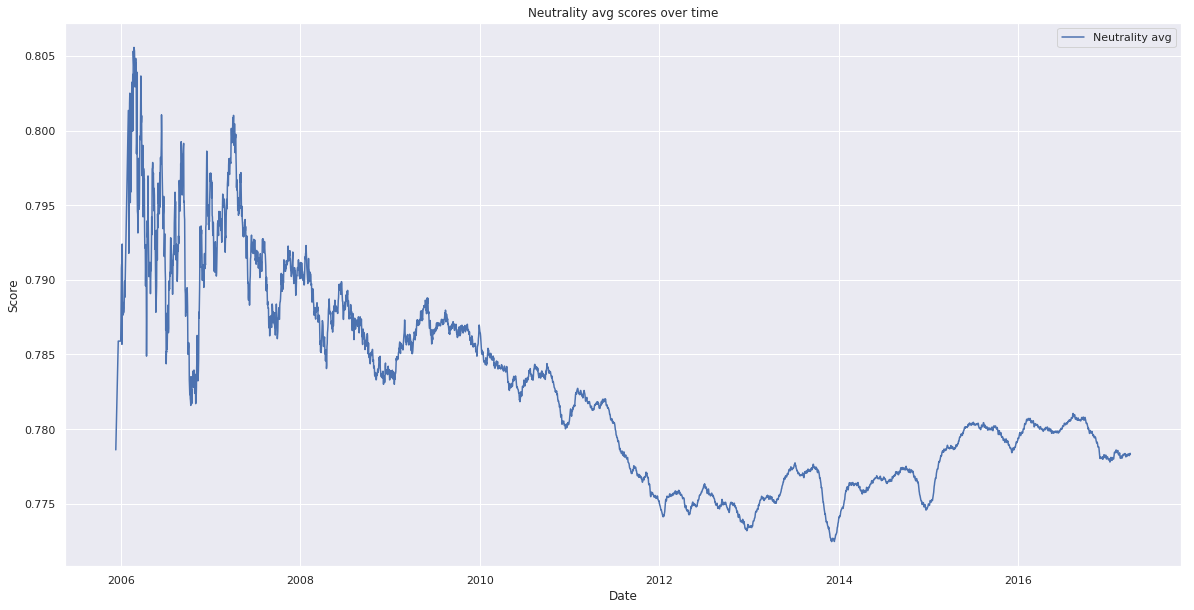

In [158]:
nltk_plot_averages(neg=False, pos=False)

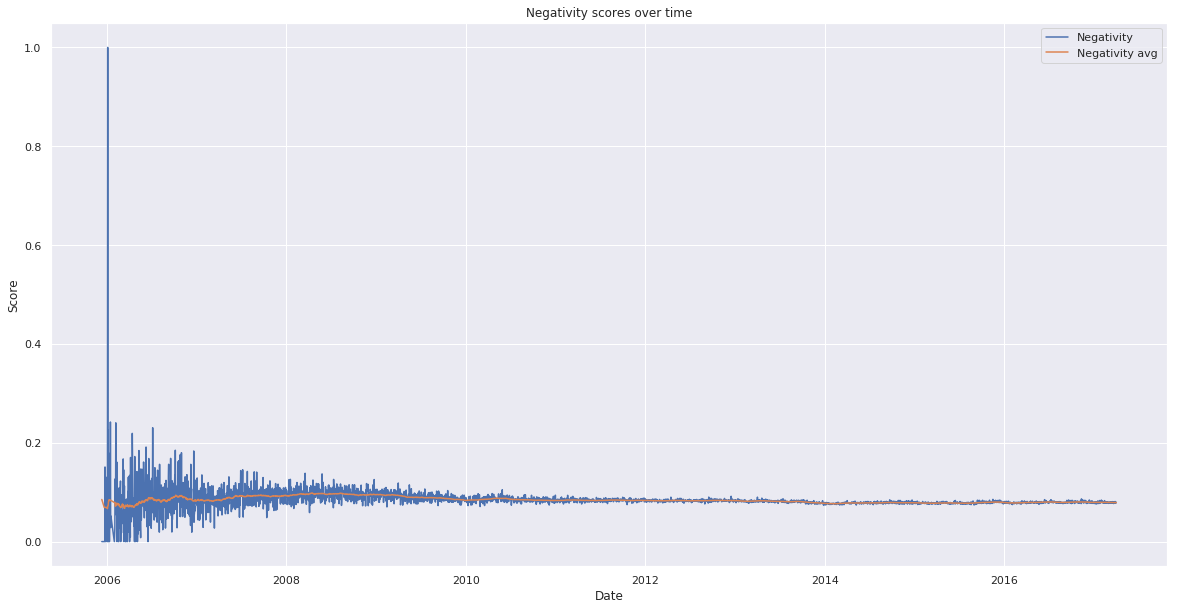

In [159]:
nltk_plot_stat(neg=True)

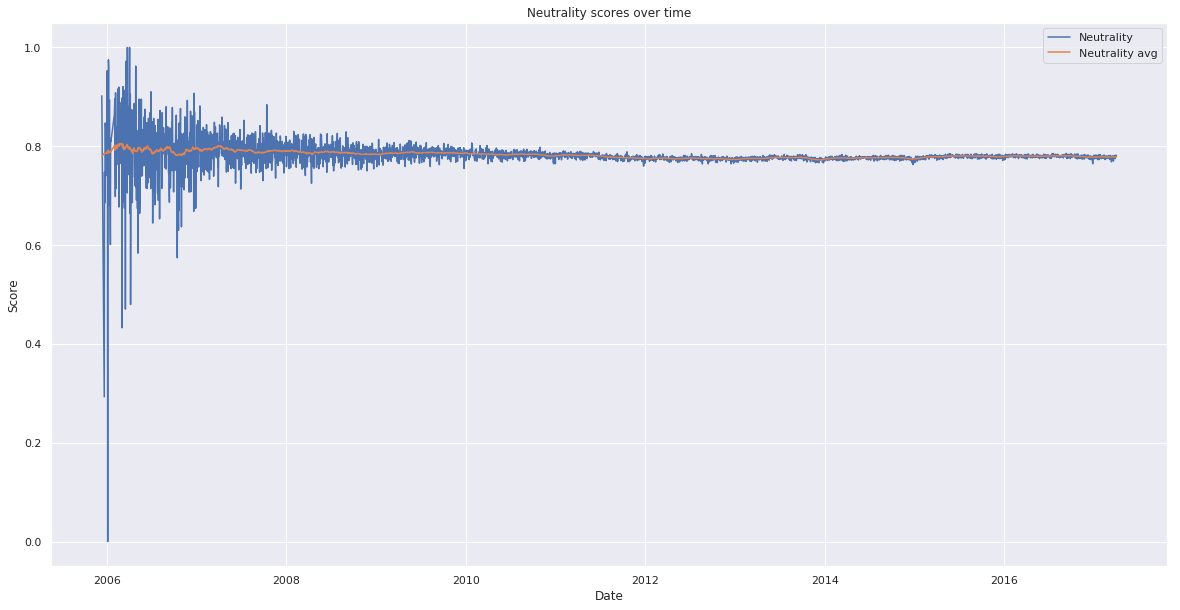

In [160]:
nltk_plot_stat(neu=True)

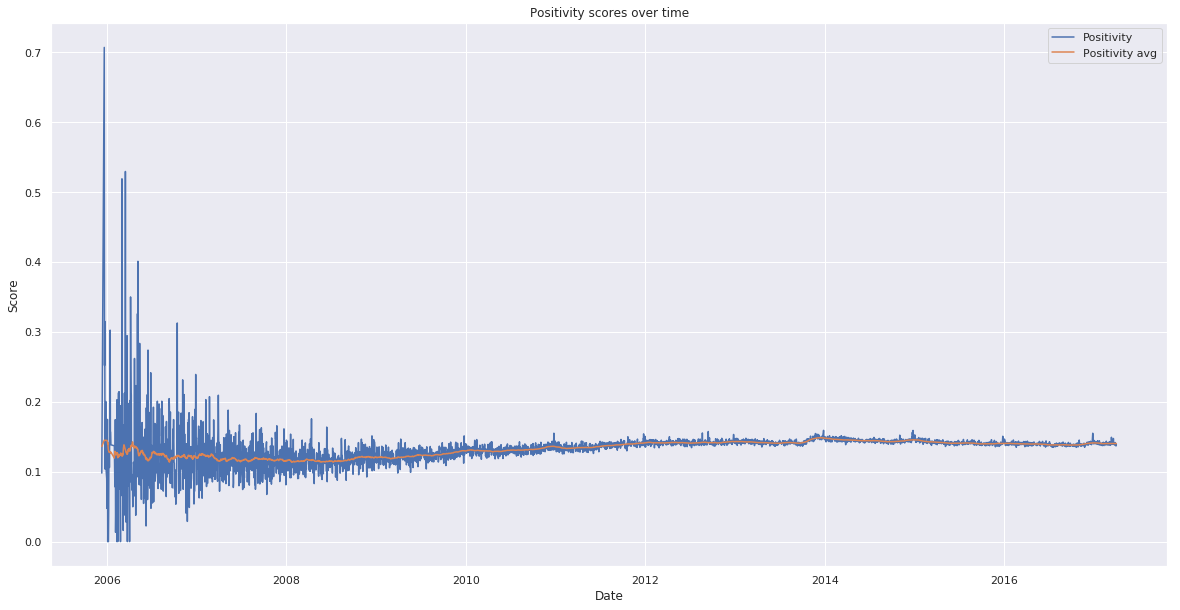

In [161]:
nltk_plot_stat(pos=True)

#### NLTK 2015 - 2017

In [162]:
nltk_plot_averages, nltk_plot_stat = plot_nltk_metrics(nltk_15_17_name, nltk_sql_query, nltk_sql_table_name)

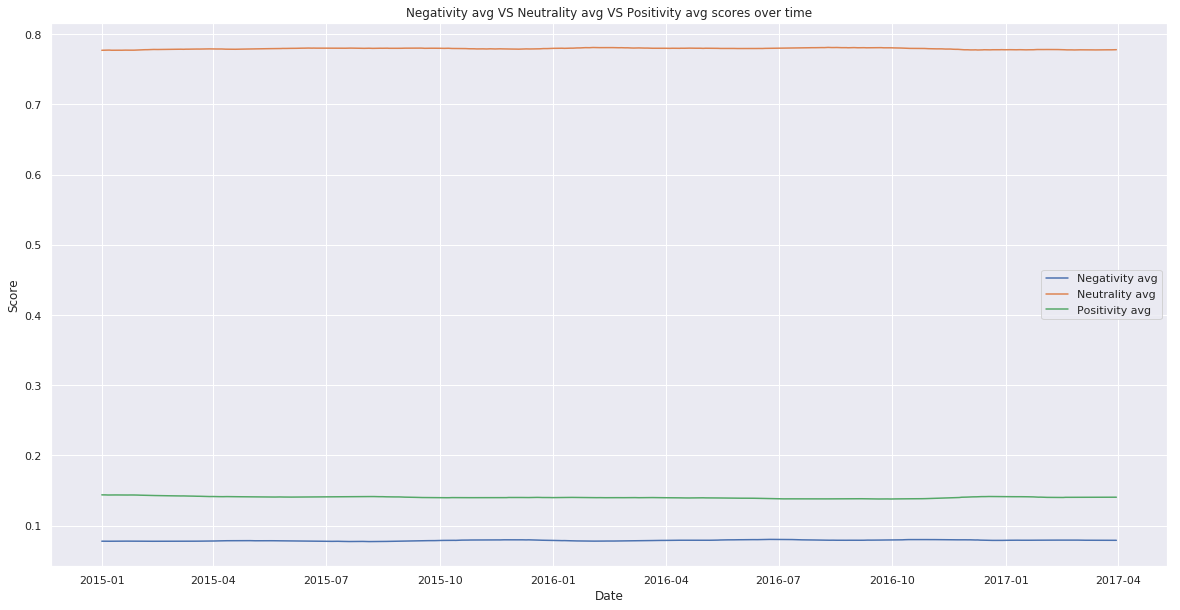

In [163]:
nltk_plot_averages()

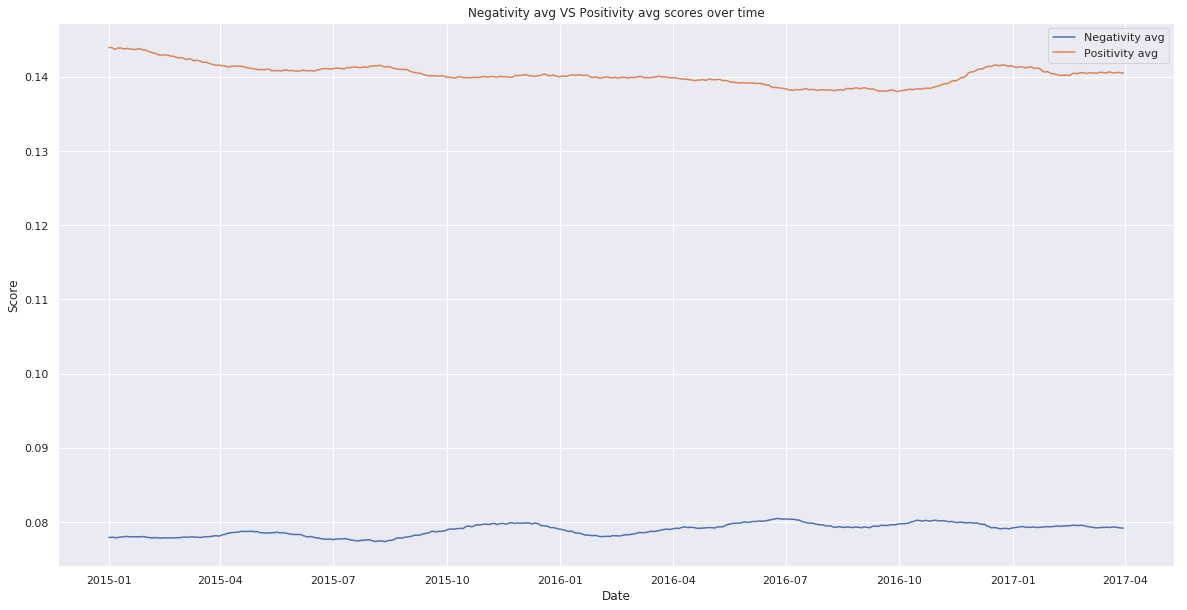

In [164]:
nltk_plot_averages(neu=False)

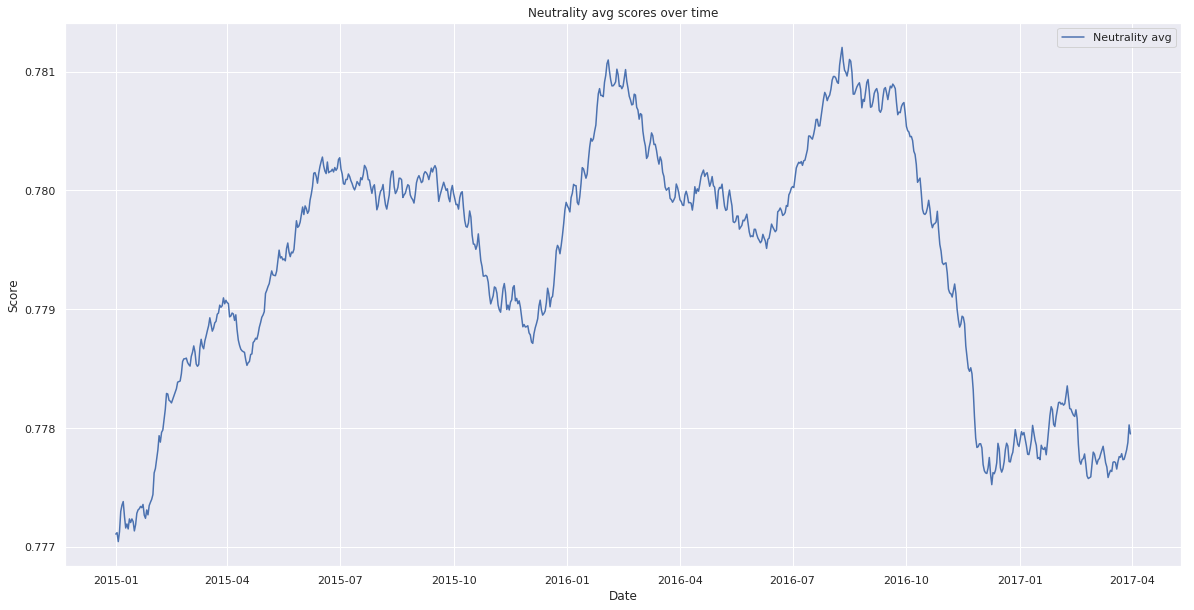

In [165]:
nltk_plot_averages(neg=False, pos=False)

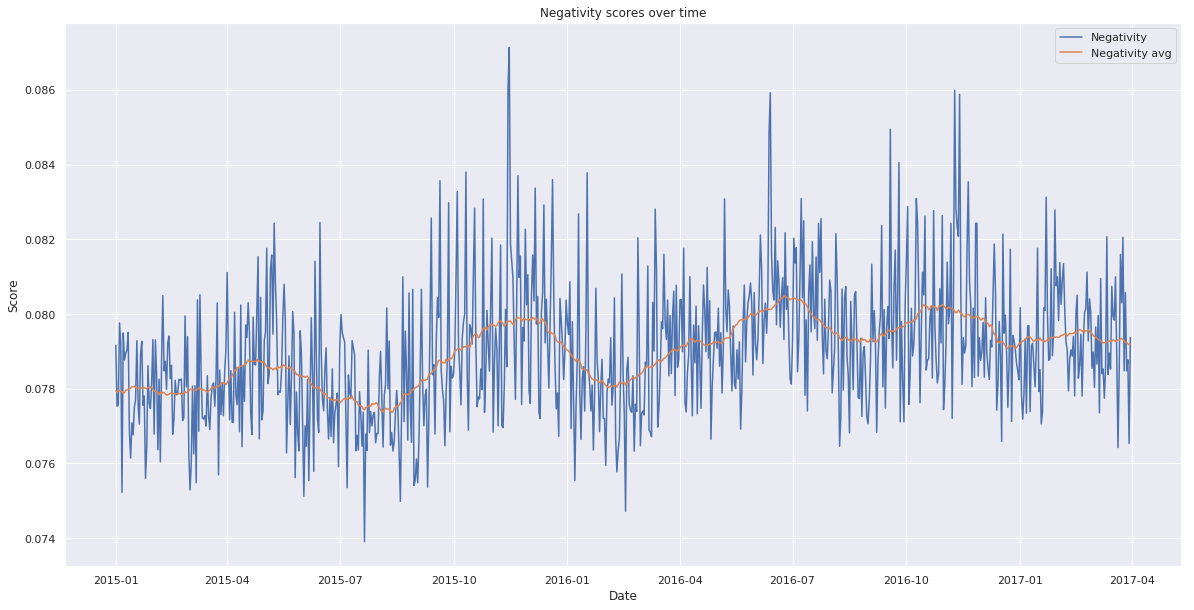

In [166]:
nltk_plot_stat(neg=True)

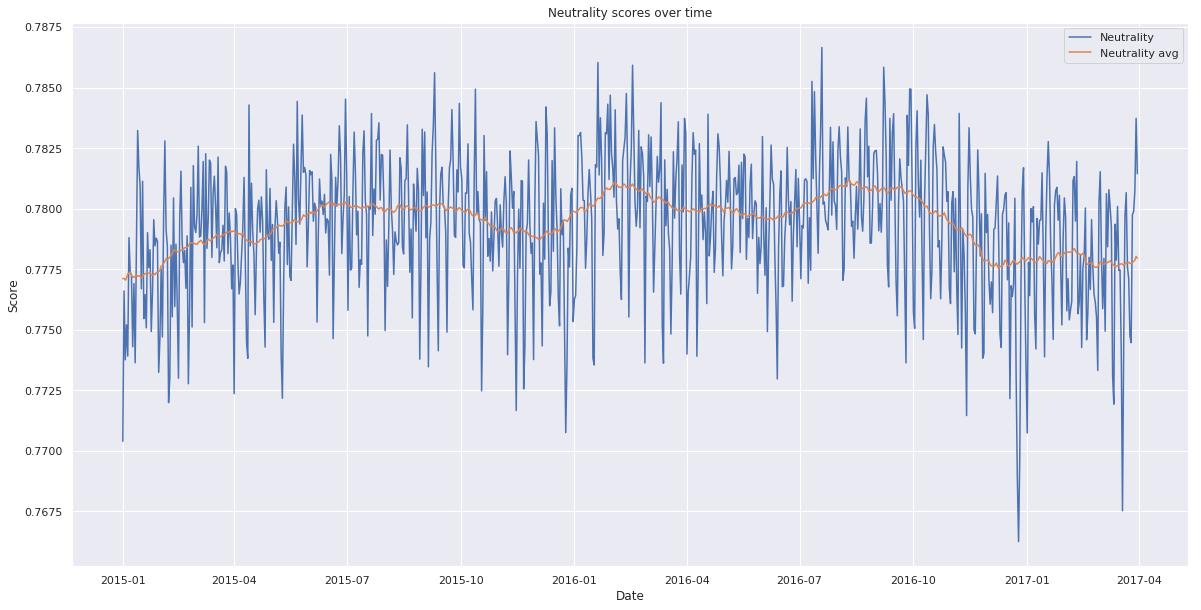

In [167]:
nltk_plot_stat(neu=True)

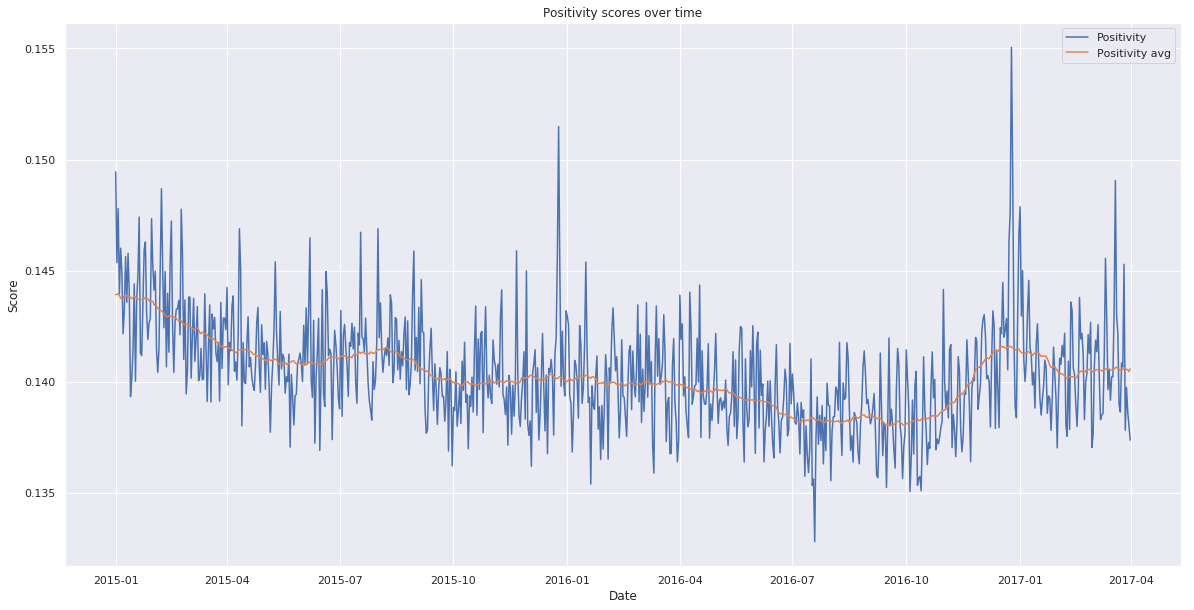

In [168]:
nltk_plot_stat(pos=True)

### TextBlob Metrics

In [169]:
blob_full_name = '../data/nlp_blob_metrics_daily_full_0.01.parquet/'
blob_15_17_name = '../data/nlp_blob_metrics_daily_15_17_0.1.parquet/'

blob_sql_table_name = 'blob_metrics'
blob_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_blob_polarity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS text_blob_polarity_60d_avg,

    AVG(sum_blob_subjectivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS text_blob_subjectivity_60d_avg

FROM {blob_sql_table_name}
""")

def plot_blob_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(pol=False, pol_avg=False, subj=False, subj_avg=False):
        if pol_avg or pol or subj_avg or subj:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if pol:
                plt.plot(m_n['sum_blob_polarity'])
                title = 'Polarity'
                labels.append('Polarity')
            if pol_avg:
                plt.plot(m_avg_n['text_blob_polarity_60d_avg'])
                title = 'Polarity avg' if title is None else title + ' VS Polarity avg'
                labels.append('Polarity avg')
            if subj:
                plt.plot(m_n['sum_blob_subjectivity'])
                title = 'Subjectivity' if title is None else title + ' VS Subjectivity'
                labels.append('Subjectivity')
            if subj_avg:
                plt.plot(m_avg_n['text_blob_subjectivity_60d_avg'])
                title = 'Subjectivity avg' if title is None else title + ' VS Subjectivity avg'
                labels.append('Subjectivity avg')
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [pol, pol_avg, subj, subj_avg]')
            
    return plot_stat

#### Blob 2005 - 2017

In [170]:
blob_plot_stat = plot_blob_metrics(blob_full_name, blob_sql_query, blob_sql_table_name)

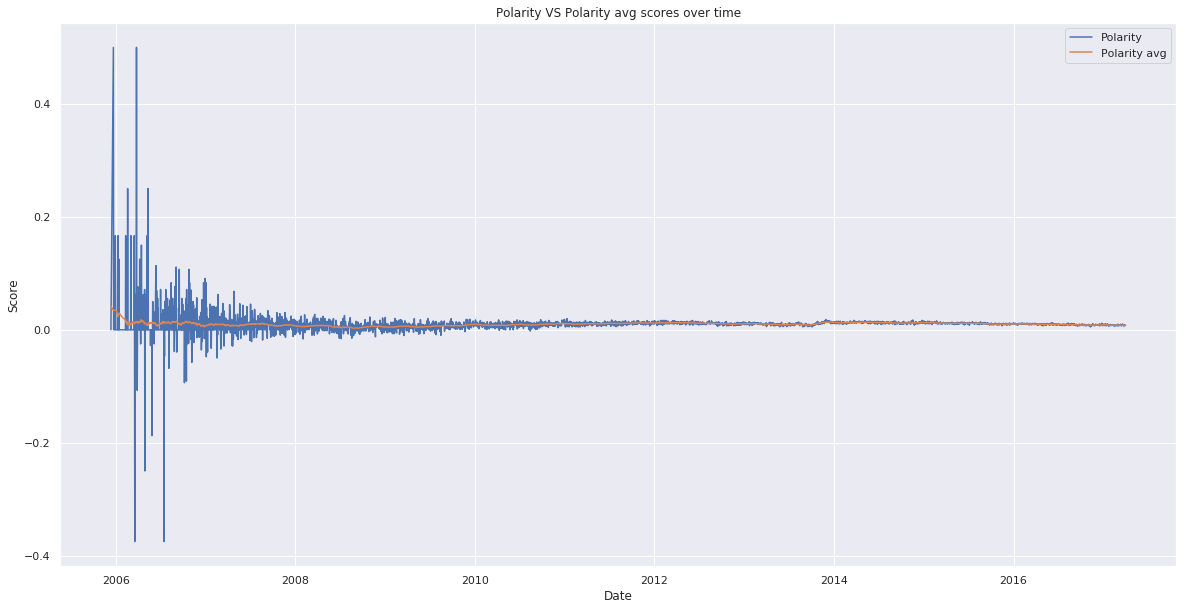

In [171]:
blob_plot_stat(pol=True, pol_avg=True)

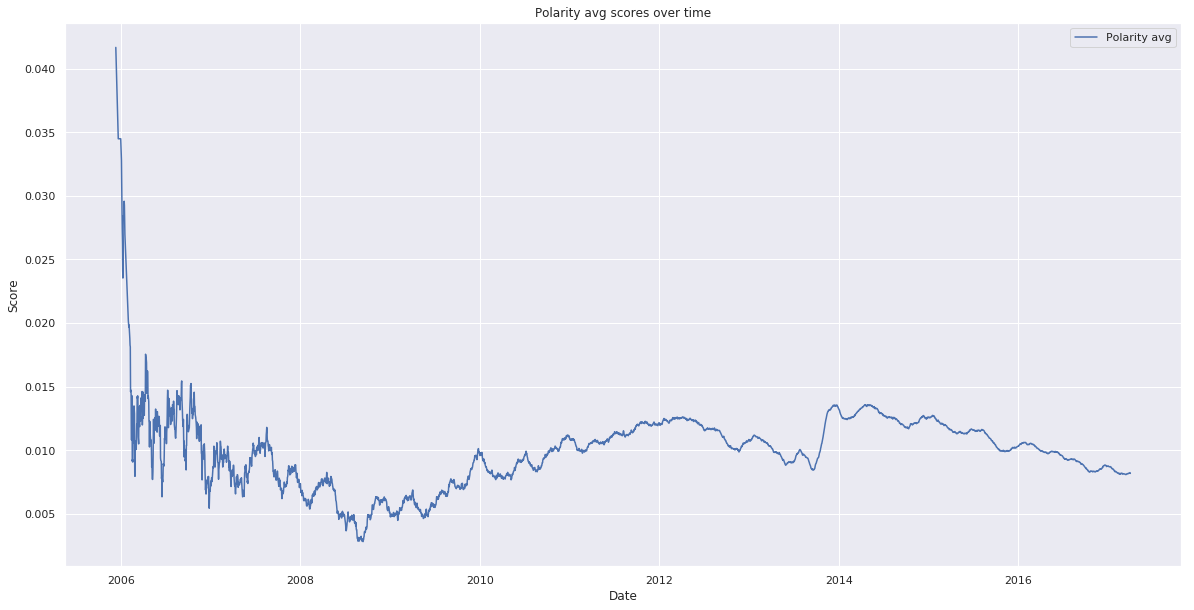

In [172]:
blob_plot_stat(pol_avg=True)

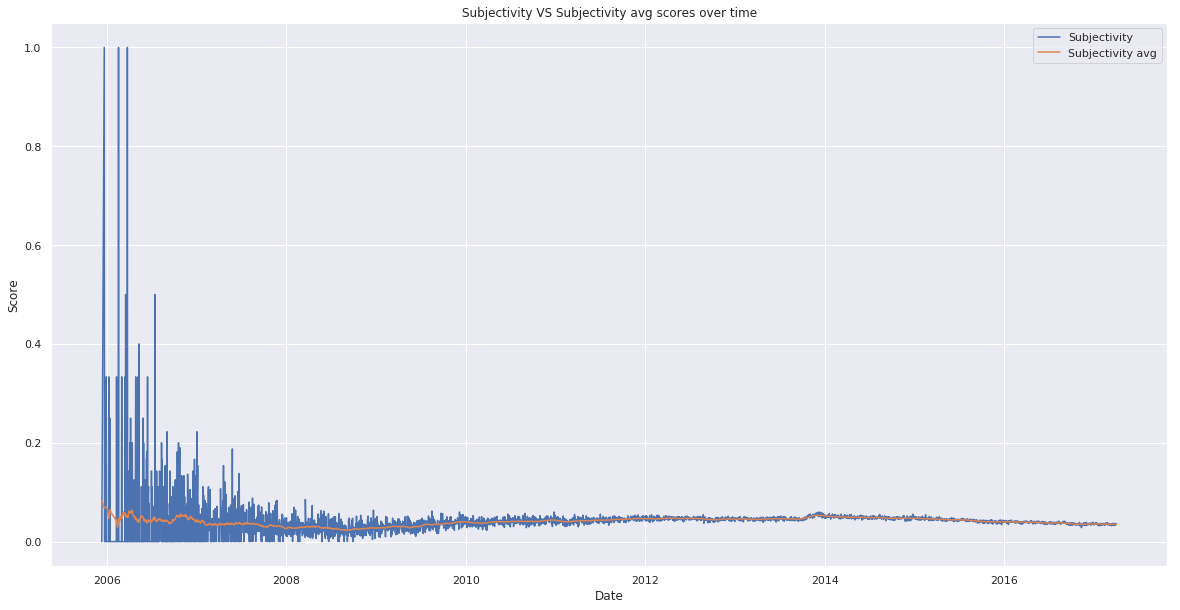

In [173]:
blob_plot_stat(subj=True, subj_avg=True)

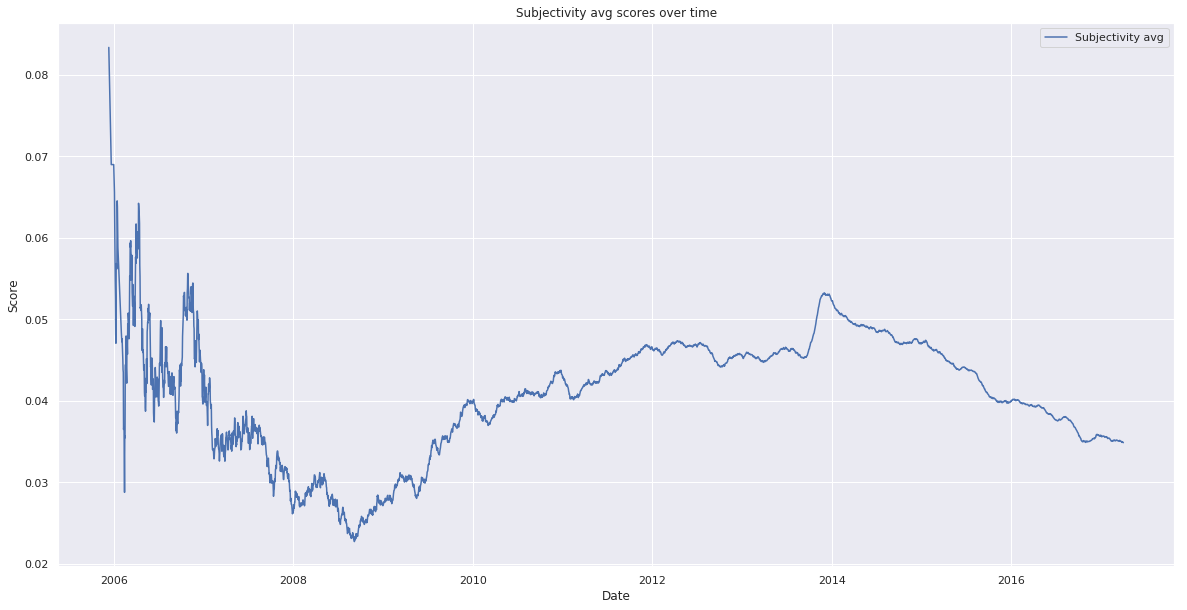

In [174]:
blob_plot_stat(subj_avg=True)

#### Blob 2015-2017

In [175]:
blob_plot_stat = plot_blob_metrics(blob_15_17_name, blob_sql_query, blob_sql_table_name)

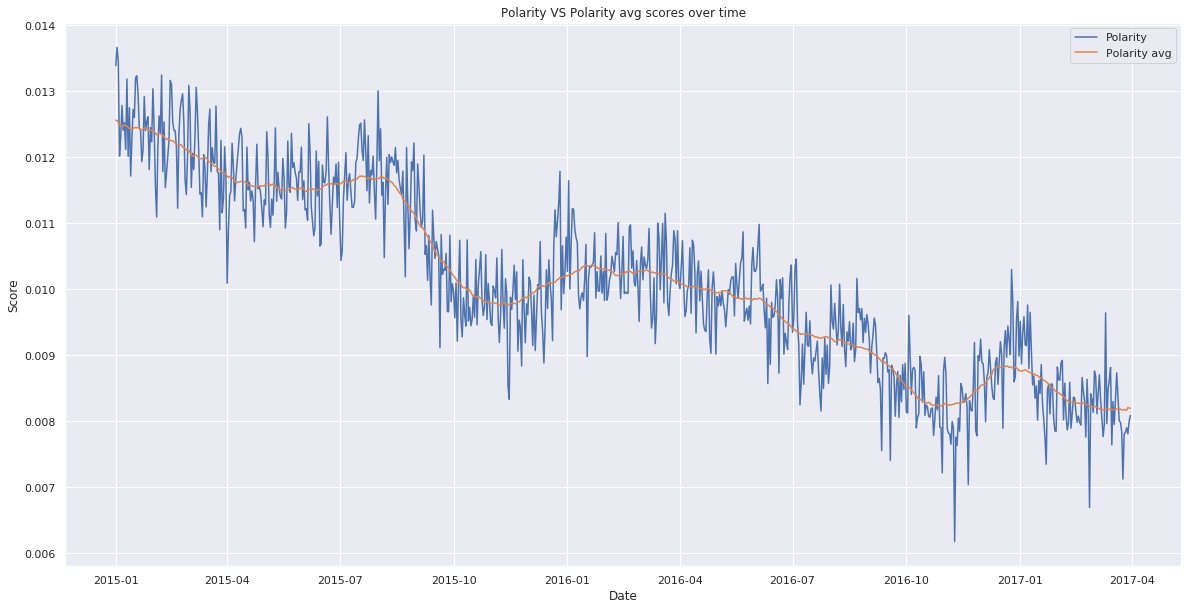

In [176]:
blob_plot_stat(pol=True, pol_avg=True)

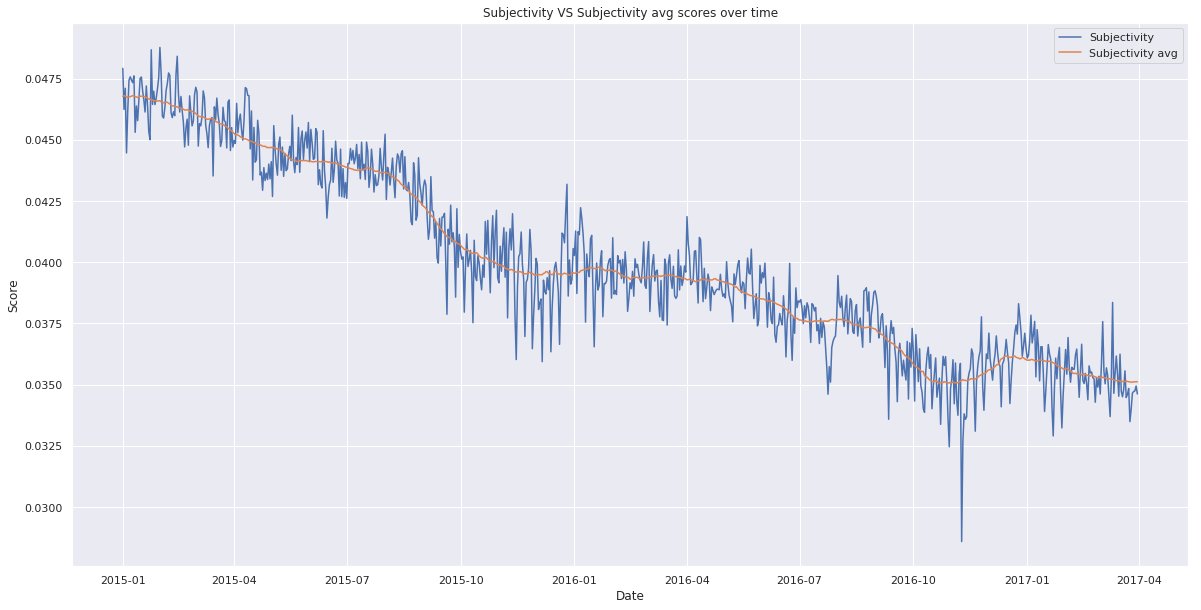

In [177]:
blob_plot_stat(subj=True, subj_avg=True)

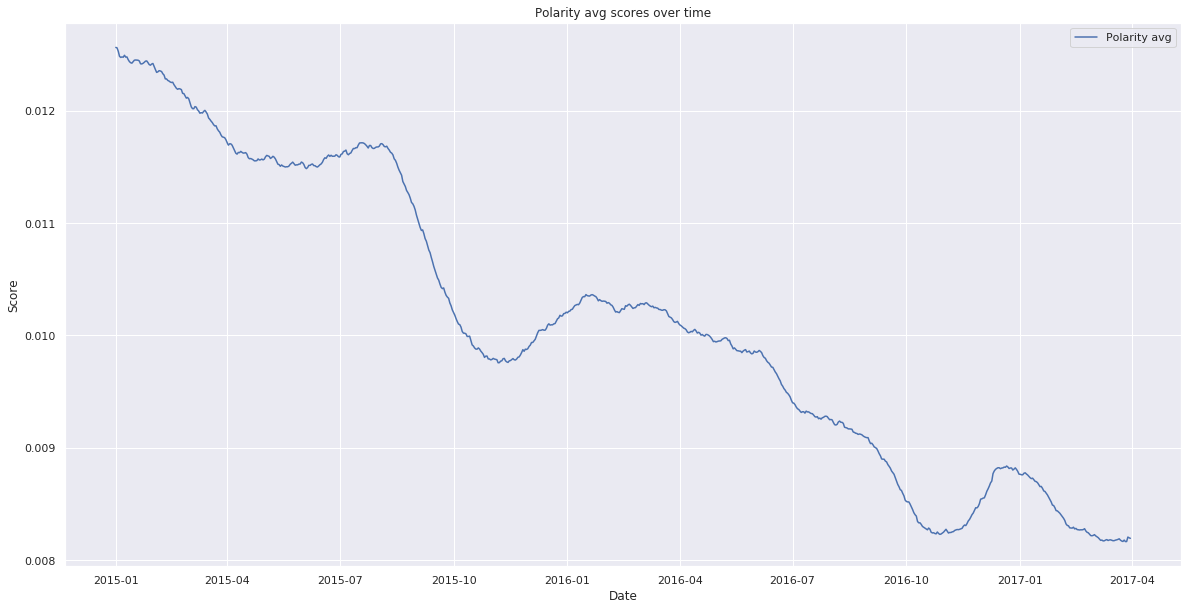

In [178]:
blob_plot_stat(pol_avg=True)

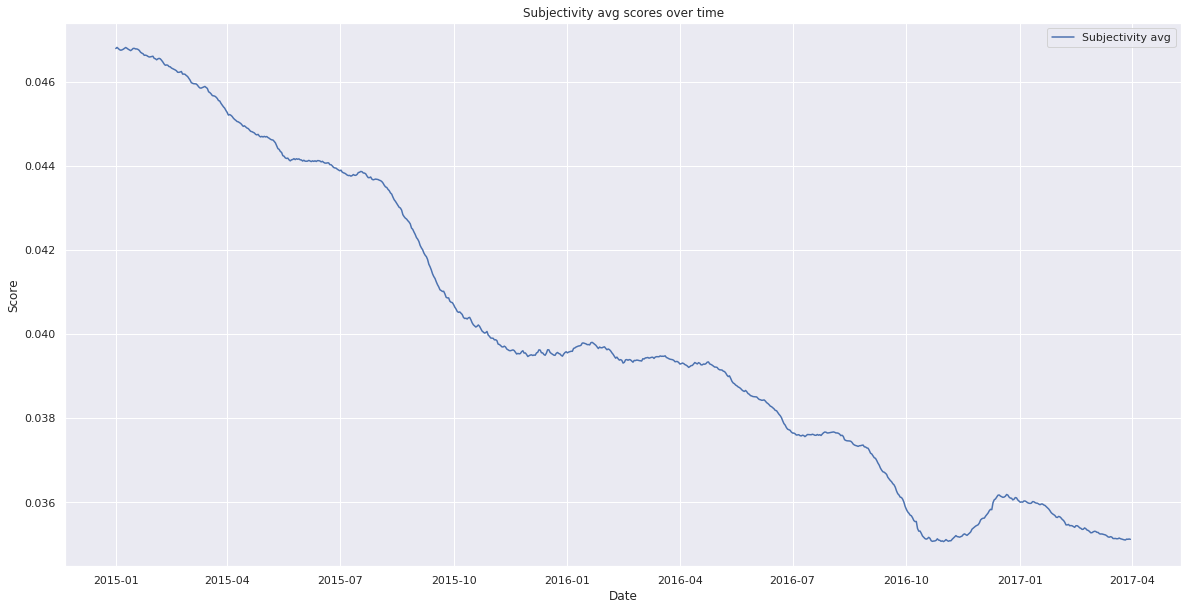

In [179]:
blob_plot_stat(subj_avg=True)

### Bad words metrics

In [180]:
bw_full_name = '../data/nlp_bw_metrics_daily_full_0.01.parquet/'
bw_15_17_name = '../data/nlp_bw_metrics_daily_15_17_0.1.parquet/'

bw_sql_table_name = 'bw_metrics'
bw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nb_bw_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_bw_matches_60d_avg

FROM {bw_sql_table_name}
""")

def plot_bw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(bw=False, bw_avg=False):
        if bw or bw_avg:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if bw:
                plt.plot(m_n['sum_nb_bw_matches'])
                title = 'Bad words'
                labels.append('Bad words')
            if bw_avg:
                plt.plot(m_avg_n['nb_bw_matches_60d_avg'])
                title = 'Bad words avg' if title is None else title + ' VS Bad words avg'
                labels.append('Bad words avg')
                
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [bw, bw_avg]')
            
    return plot_stat

#### Bad words 2005-2017

In [181]:
bw_plot_stat = plot_bw_metrics(bw_full_name, bw_sql_query, bw_sql_table_name)

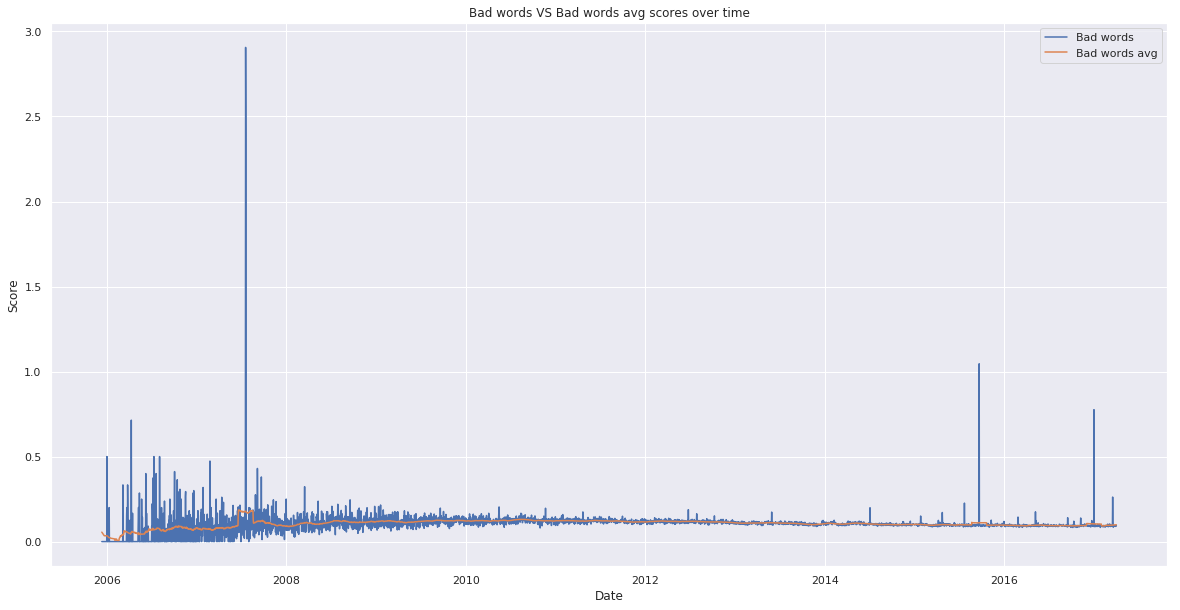

In [182]:
bw_plot_stat(bw=True, bw_avg=True)

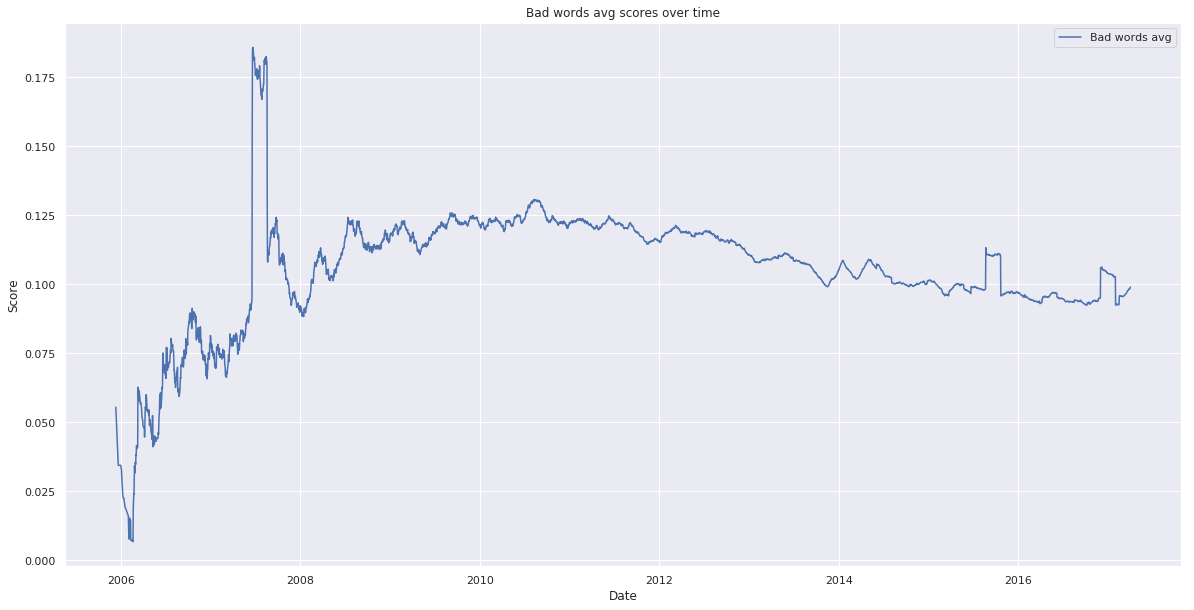

In [183]:
bw_plot_stat(bw_avg=True)

#### Bad words 2015-2017

In [184]:
bw_plot_stat = plot_bw_metrics(bw_15_17_name, bw_sql_query, bw_sql_table_name)

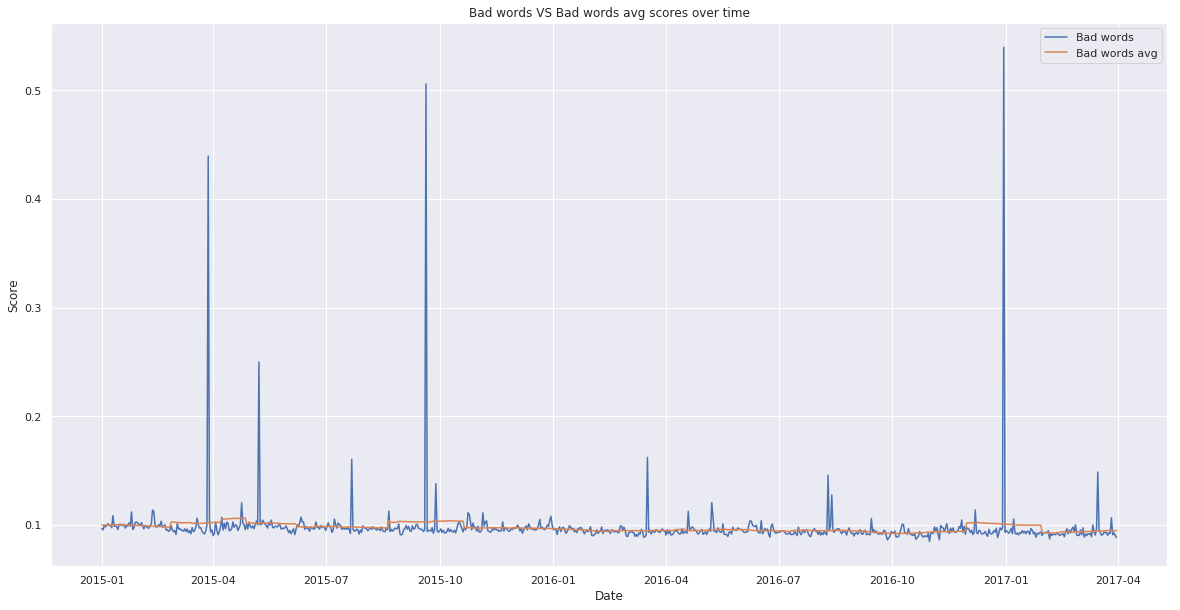

In [185]:
bw_plot_stat(bw=True, bw_avg=True)

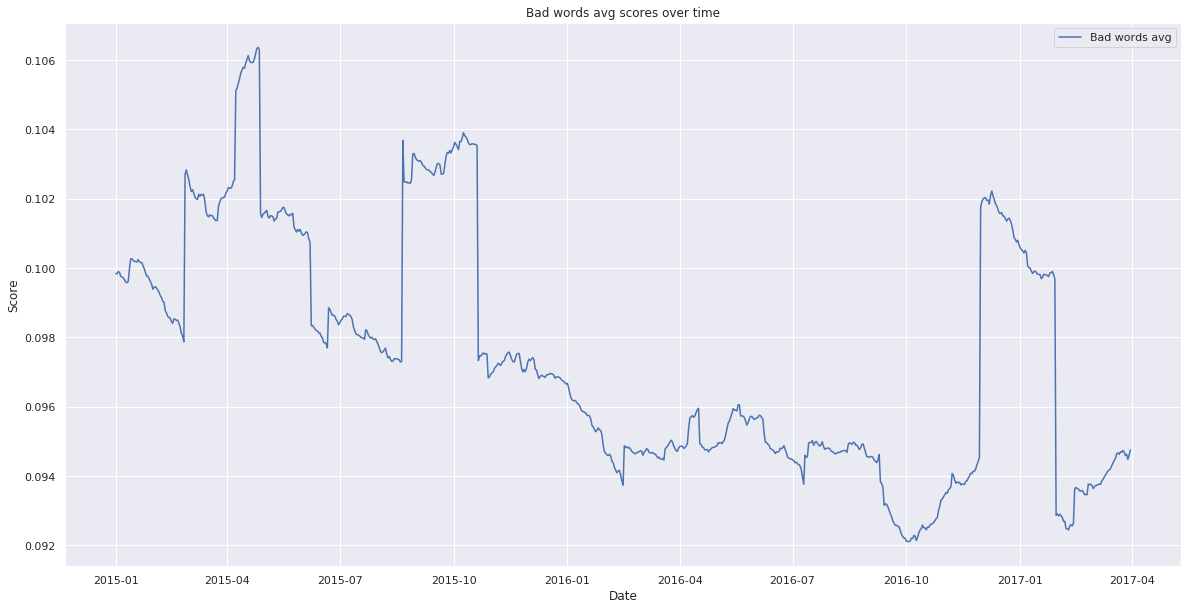

In [186]:
bw_plot_stat(bw_avg=True)

### Hate words metrics

In [188]:
hw_full_name = '../data/nlp_hw_metrics_daily_full_0.01.parquet/'
hw_15_17_name = '../data/nlp_hw_metrics_daily_15_17_0.1.parquet/'

hw_sql_table_name = 'hw_metrics'
hw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nb_hw_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_hw_matches_60d_avg

FROM {hw_sql_table_name}
""")

def plot_hw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(hw=False, hw_avg=False):
        if hw or hw_avg:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if hw:
                plt.plot(m_n['sum_nb_hw_matches'])
                title = 'Hate words'
                labels.append('Hate words')
            if hw_avg:
                plt.plot(m_avg_n['nb_hw_matches_60d_avg'])
                title = 'Hate words avg' if title is None else title + ' VS Hate words avg'
                labels.append('Hate words avg')
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [hw, hw_avg]')
            
    return plot_stat

#### Hate words 2005-2017

In [189]:
hw_plot_stat = plot_hw_metrics(hw_full_name, hw_sql_query, hw_sql_table_name)

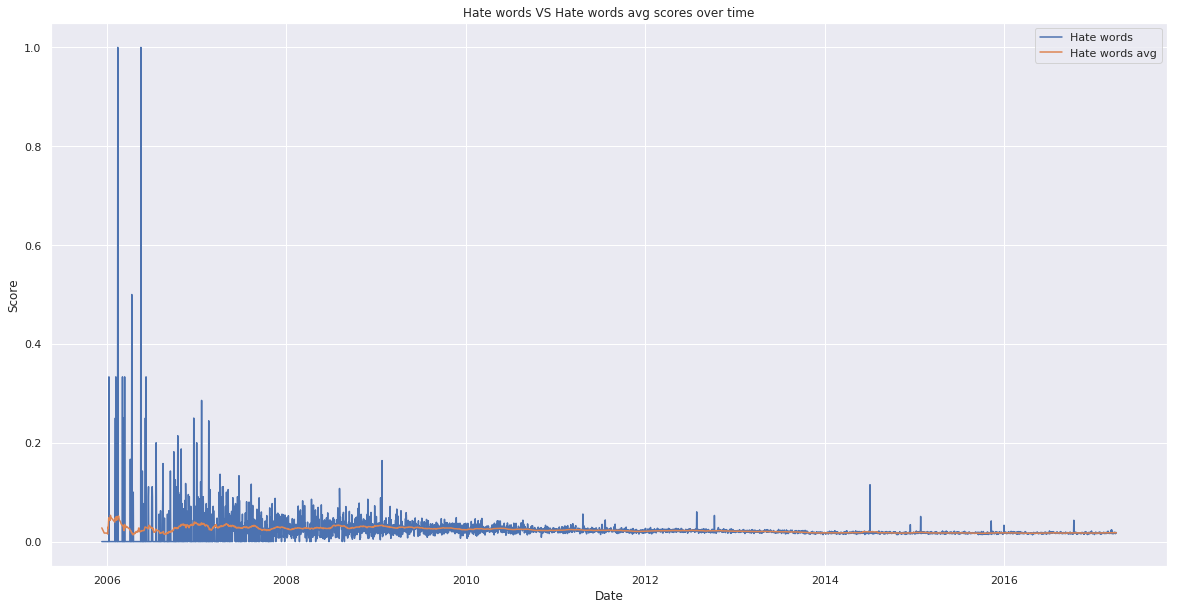

In [190]:
hw_plot_stat(hw=True, hw_avg=True)

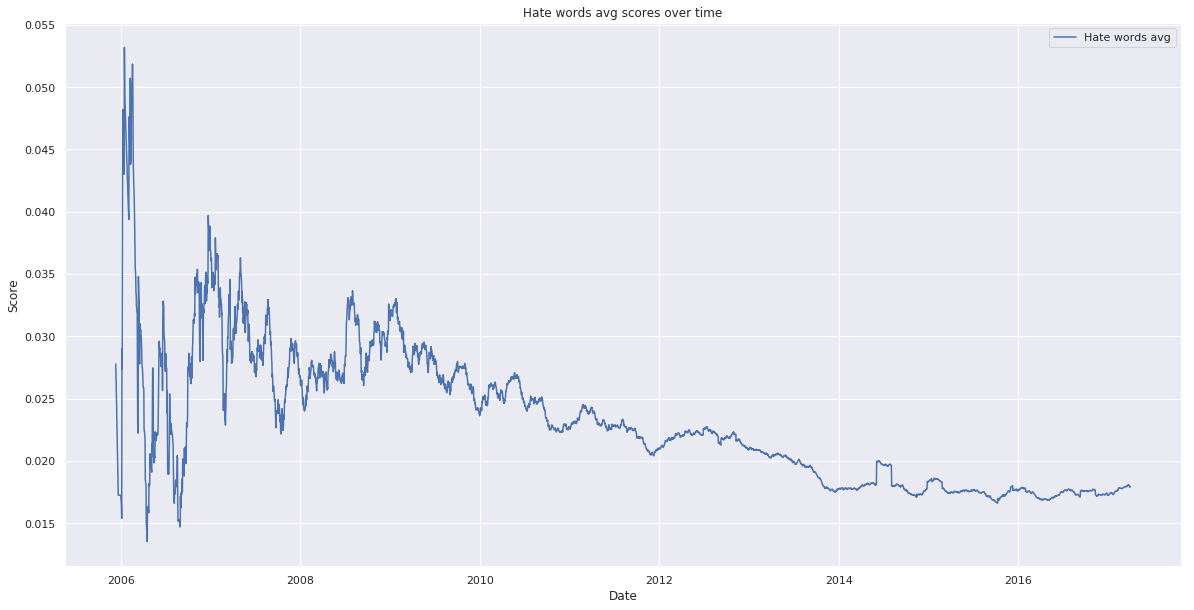

In [191]:
hw_plot_stat(hw_avg=True)

#### Hate words 2015-2017

In [192]:
hw_plot_stat = plot_hw_metrics(hw_15_17_name, hw_sql_query, hw_sql_table_name)

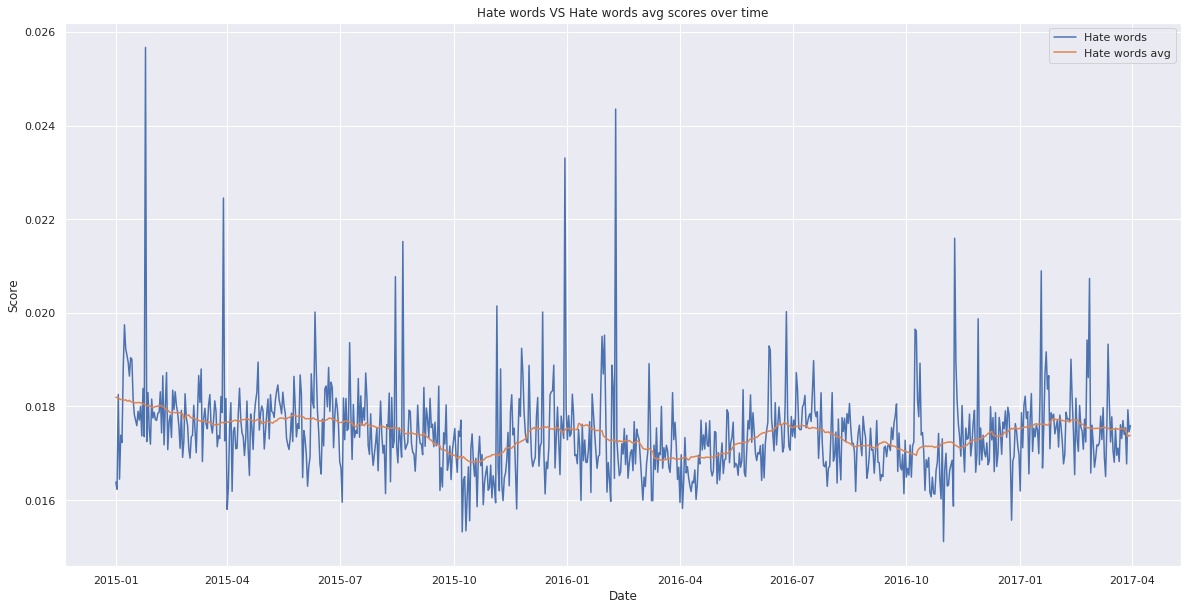

In [193]:
hw_plot_stat(hw=True, hw_avg=True)

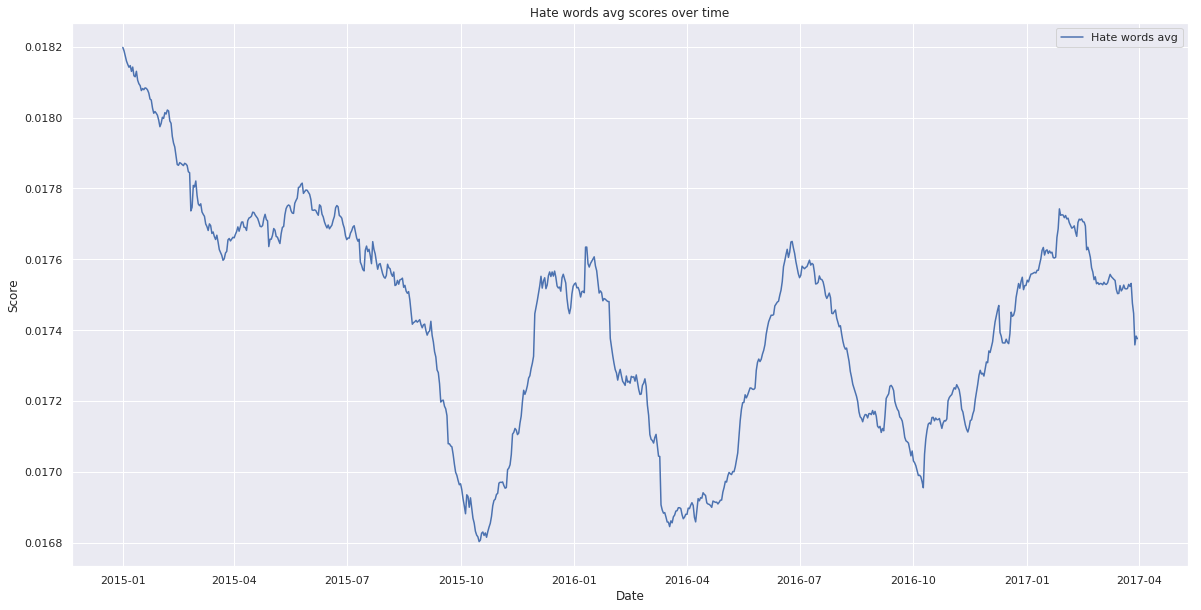

In [194]:
hw_plot_stat(hw_avg=True)

### Refined Hate Words

In [195]:
ref_hw_full_name = '../data/nlp_ref_hw_metrics_daily_full_0.01.parquet/'
ref_hw_15_17_name = '../data/nlp_ref_hw_metrics_daily_15_17_0.1.parquet/'

ref_hw_sql_table_name = 'ref_hw_metrics'
ref_hw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,
    
    AVG(sum_hw_ref_intensity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS hw_ref_intensity_60d_avg,

    AVG(sum_nb_hw_ref_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_hw_ref_matches_60d_avg

FROM {ref_hw_sql_table_name}
""")

def plot_ref_hw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(ref_hw=False, ref_hw_avg=False, intensity=False, intensity_avg=False):
        if ref_hw or ref_hw_avg or intensity or intensity_avg:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if ref_hw:
                plt.plot(m_n['sum_nb_hw_ref_matches'])
                title = 'Hate words refined'
                labels.append('Hate words refined')
            if ref_hw_avg:
                plt.plot(m_avg_n['nb_hw_ref_matches_60d_avg'])
                title = 'Hate words refined avg' if title is None else title + ' VS Hate words refined avg'
                labels.append('Hate words refined avg')
            if intensity:
                plt.plot(m_n['sum_hw_ref_intensity'])
                title = 'Hate words refined intensity' if title is None else title + ' VS Hate words refined intensity'
                labels.append('Hate words refined intensity')
            if intensity_avg:
                plt.plot(m_avg_n['hw_ref_intensity_60d_avg'])
                title = 'Hate words refined intensity avg' if title is None else title + ' VS Hate words refined intensity avg'
                labels.append('Hate words refined intensity avg')
            
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [ref_hw, ref_hw_avg, intensity, intensity_avg]')
            
    return plot_stat

In [196]:
ref_hw_plot_stat = plot_ref_hw_metrics(ref_hw_full_name, ref_hw_sql_query, ref_hw_sql_table_name)

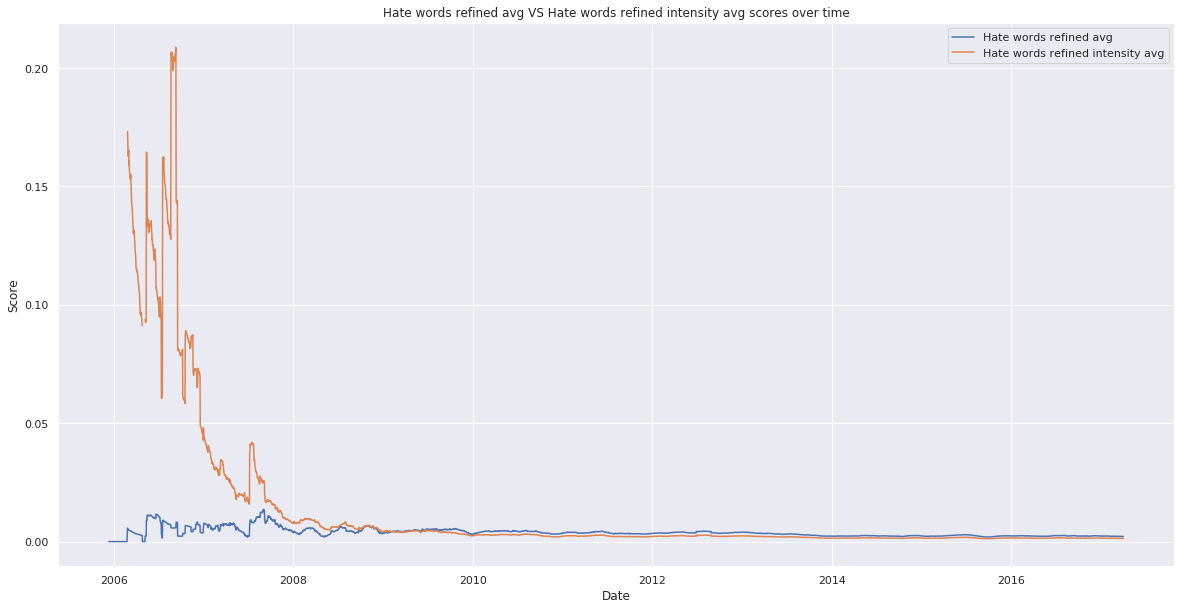

In [197]:
ref_hw_plot_stat(ref_hw_avg=True, intensity_avg=True)

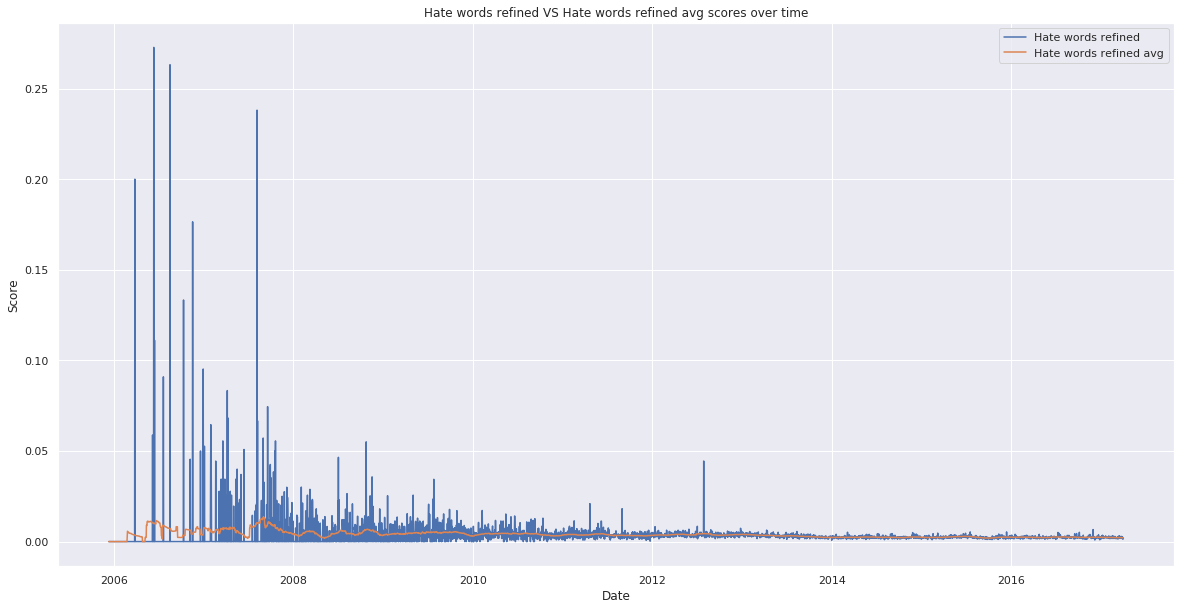

In [198]:
ref_hw_plot_stat(ref_hw=True, ref_hw_avg=True)

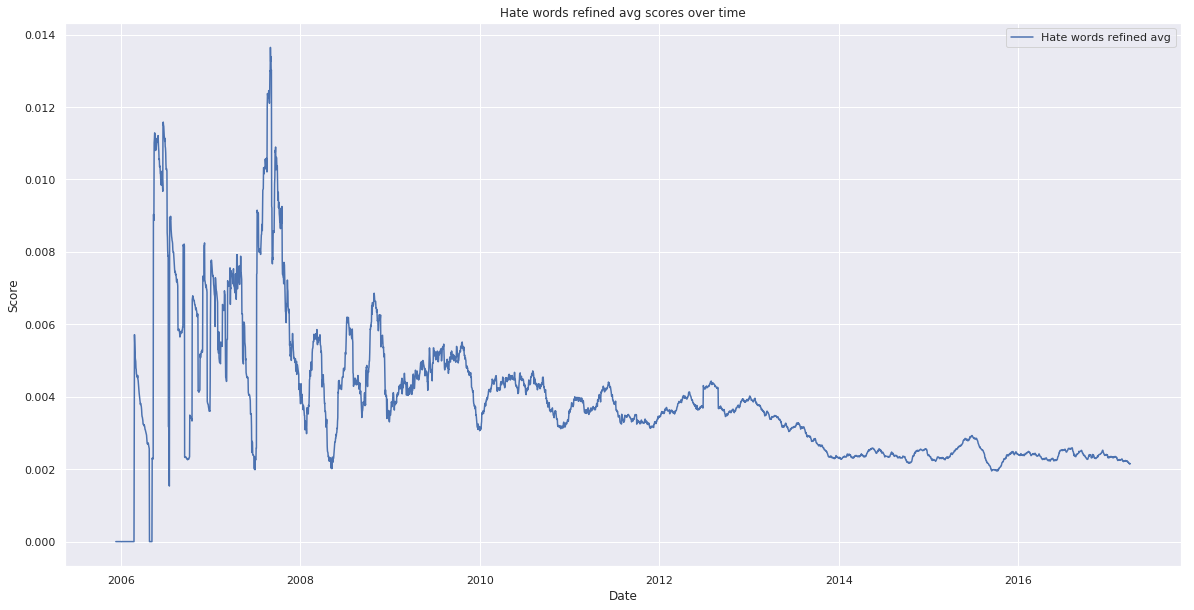

In [199]:
ref_hw_plot_stat(ref_hw_avg=True)

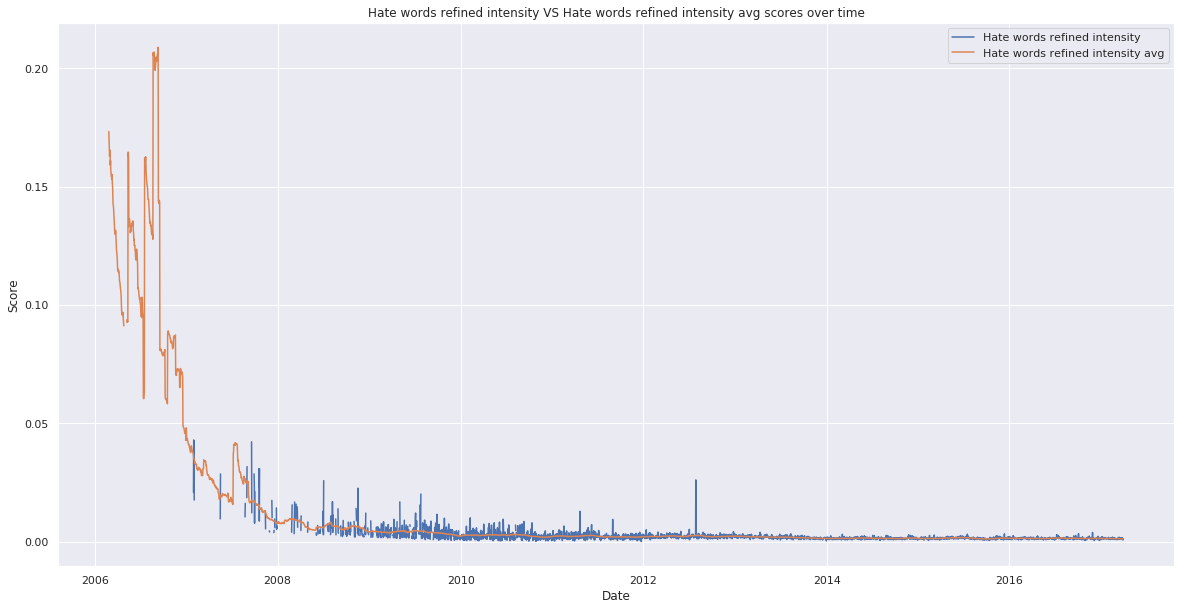

In [200]:
ref_hw_plot_stat(intensity=True, intensity_avg=True)

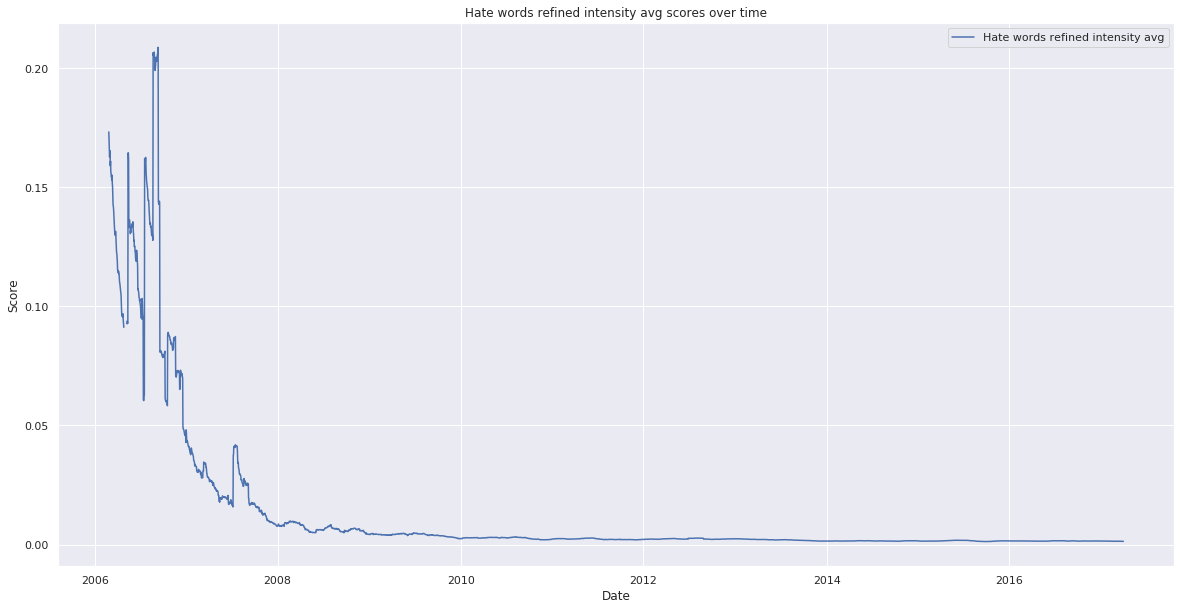

In [201]:
ref_hw_plot_stat(intensity_avg=True)

### Correlation analysis

In [52]:
nltk_n, nltk_avg_n, _, _ = get_metrics(nltk_full_name, nltk_sql_query, nltk_sql_table_name)
blob_n, blob_avg_n, _, _ = get_metrics(blob_full_name, blob_sql_query, blob_sql_table_name)
bw_n, bw_avg_n, _, _ = get_metrics(bw_full_name, bw_sql_query, bw_sql_table_name)
hw_n, hw_avg_n, _, _ = get_metrics(hw_full_name, hw_sql_query, hw_sql_table_name)
hw_ref_n, hw_ref_avg_n, _, _ = get_metrics(ref_hw_full_name, ref_hw_sql_query, ref_hw_sql_table_name)
nlp_n = pd.concat([nltk_n, blob_n, bw_n, hw_n, hw_ref_n], axis=1, sort=True).drop('msg_count', axis=1)

In [12]:
nlp_n.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref', 'intensity']
pd.to_pickle(nlp_n, '../data/daily_nlp_metrics_merged.pkl')

In [23]:
nlp_n = pd.read_pickle('../data/daily_nlp_metrics_merged.pkl').dropna()
# Remove outliers assuming gaussian distribution
nlp_n_cleaned = nlp_n[(sp.stats.zscore(nlp_n) < 3).all(axis=1)]

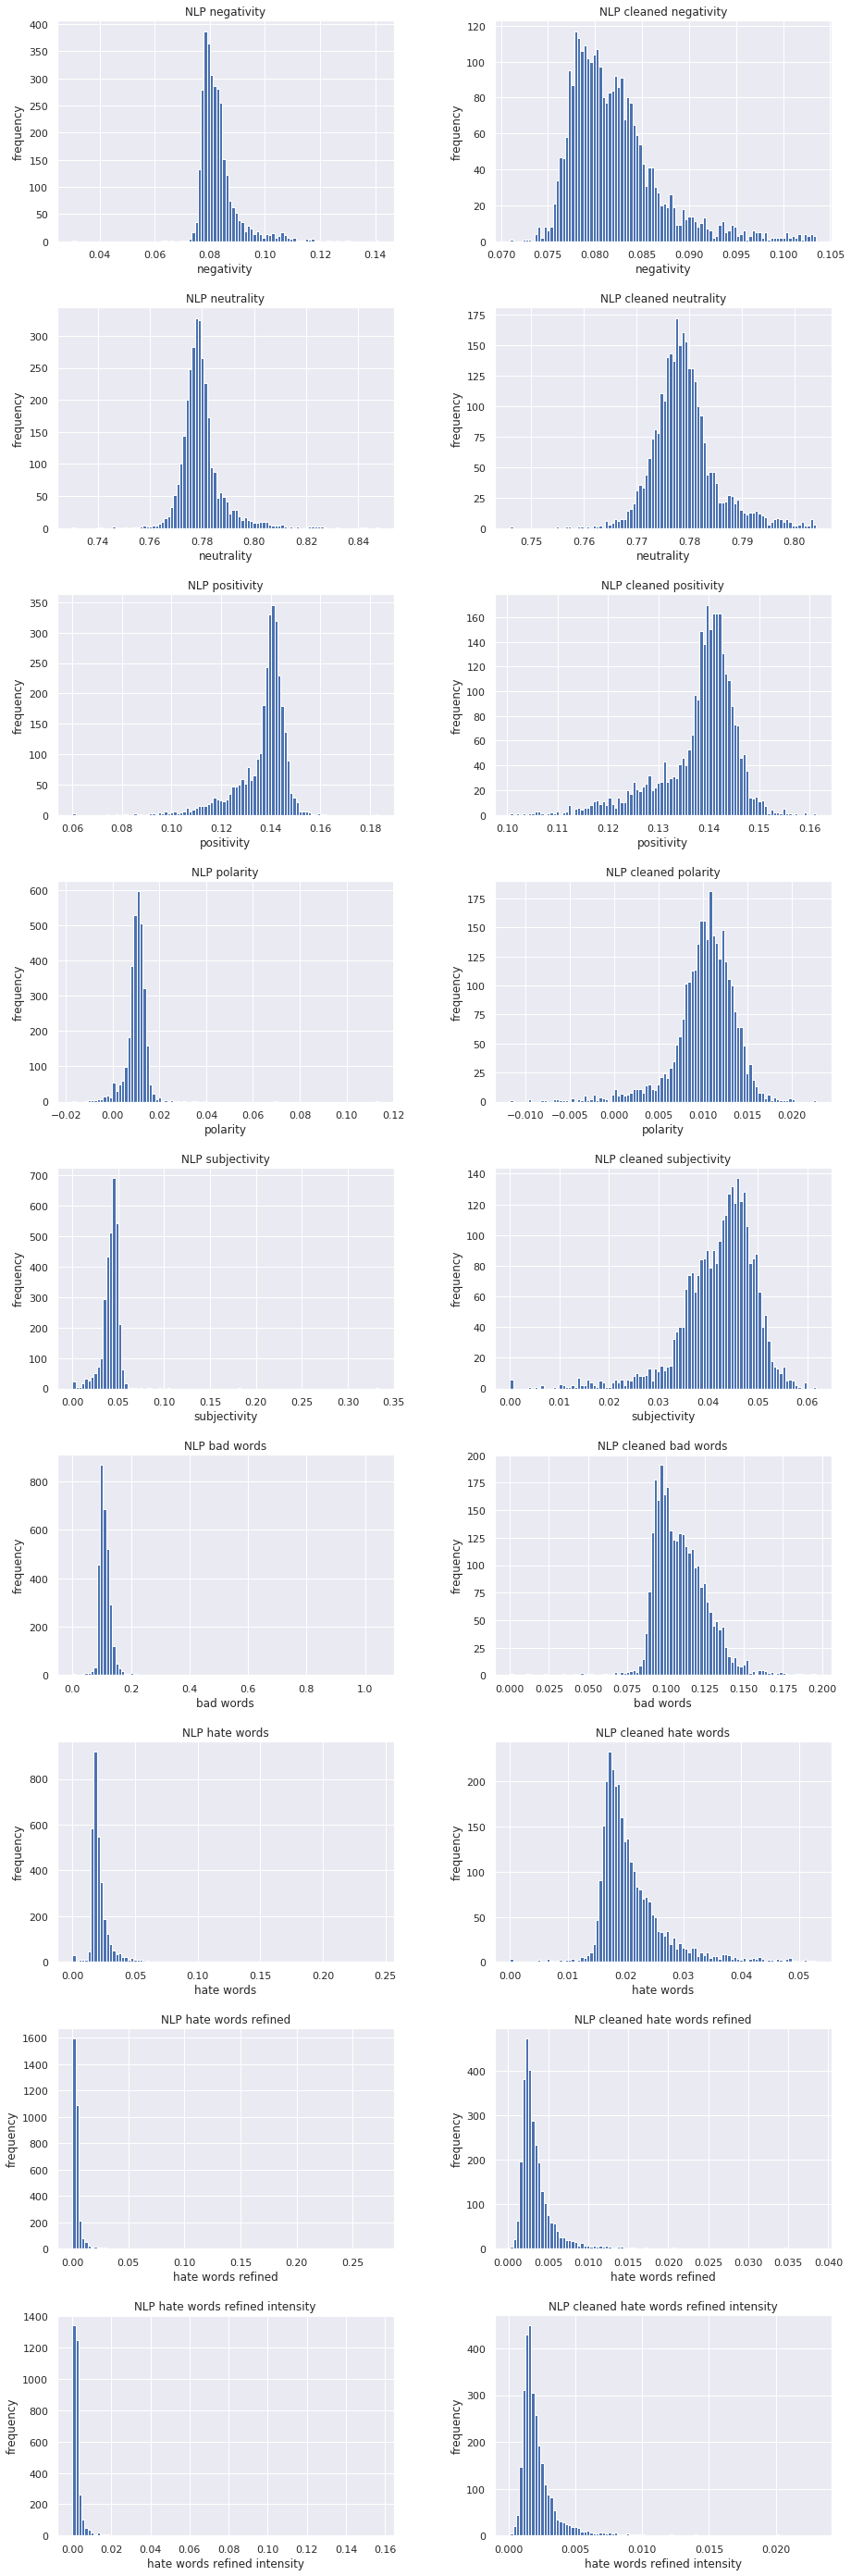

In [31]:
plot_nlp_distrib([nlp_n, nlp_n_cleaned], ['NLP', 'NLP cleaned'])

In [24]:
nlp_n.corr()

,neg,neu,pos,pol,subj,bw,hw,hw_ref,intensity
neg,1.000000,-0.063602,-0.611852,-0.313977,-0.340057,0.203699,0.349225,0.199044,0.219414
neu,-0.063602,1.000000,-0.746683,-0.134972,-0.190069,-0.014521,0.169222,0.197443,0.198851
pos,-0.611852,-0.746683,1.000000,0.324468,0.388174,-0.118232,-0.361850,-0.286737,-0.301608
pol,-0.313977,-0.134972,0.324468,1.000000,0.642685,-0.043927,-0.148082,0.120251,0.106186
subj,-0.340057,-0.190069,0.388174,0.642685,1.000000,-0.048077,-0.237977,-0.018774,-0.030310
bw,0.203699,-0.014521,-0.118232,-0.043927,-0.048077,1.000000,0.206121,0.010870,0.018229
hw,0.349225,0.169222,-0.361850,-0.148082,-0.237977,0.206121,1.000000,0.296737,0.311492
hw_ref,0.199044,0.197443,-0.286737,0.120251,-0.018774,0.010870,0.296737,1.000000,0.996249
intensity,0.219414,0.198851,-0.301608,0.106186,-0.030310,0.018229,0.311492,0.996249,1.000000


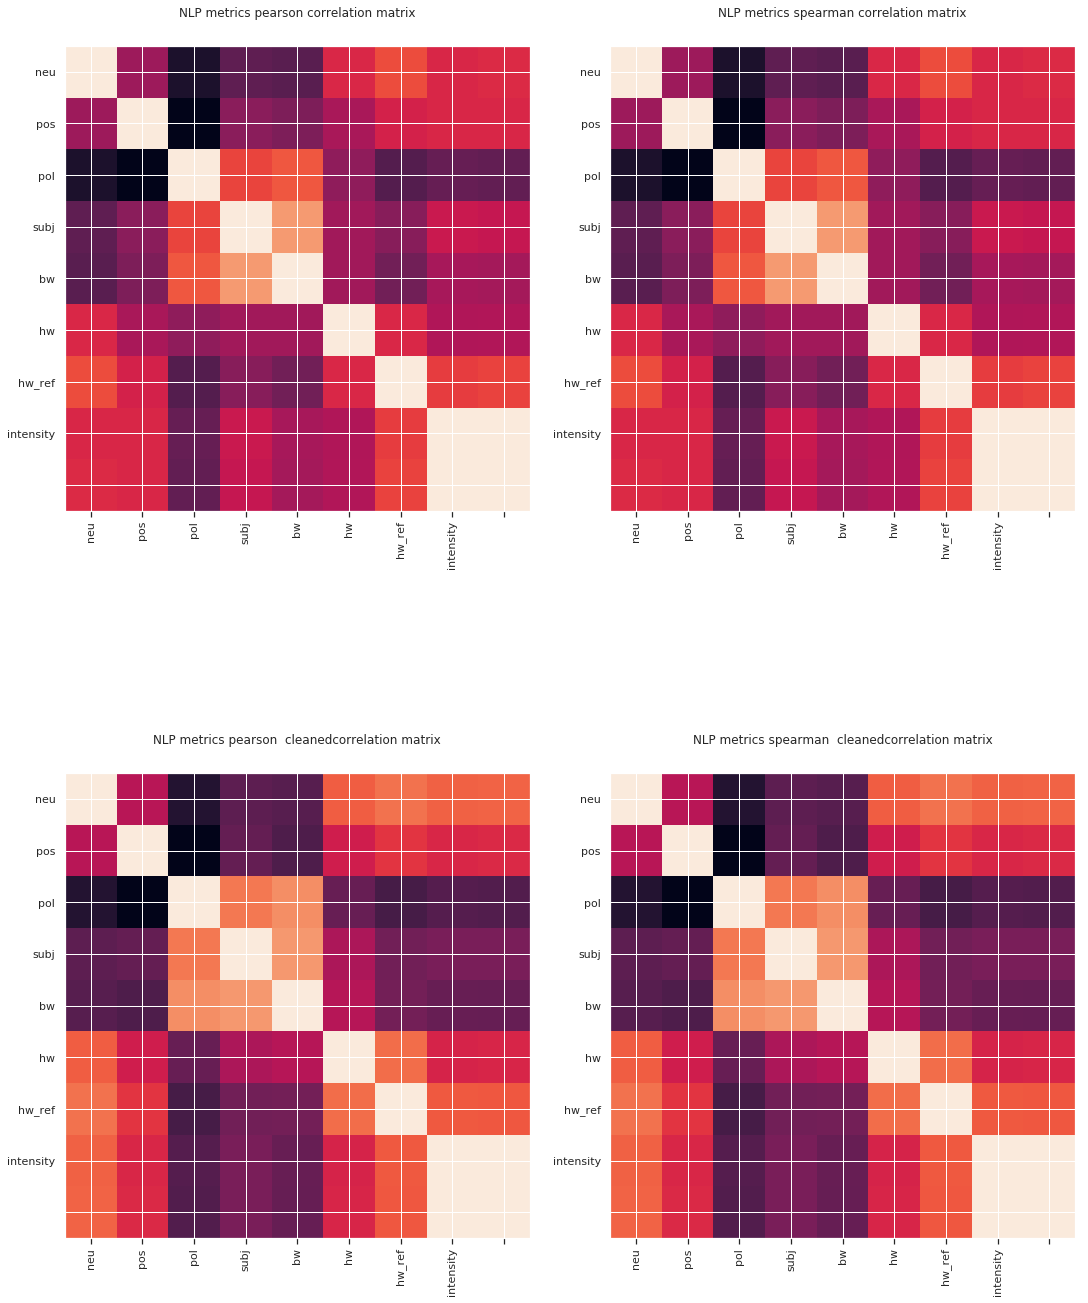

In [25]:
plot_corr_mats([nlp_n, nlp_n_cleaned], 'NLP metrics', ['pearson', 'spearman'], ['', ' cleaned'])

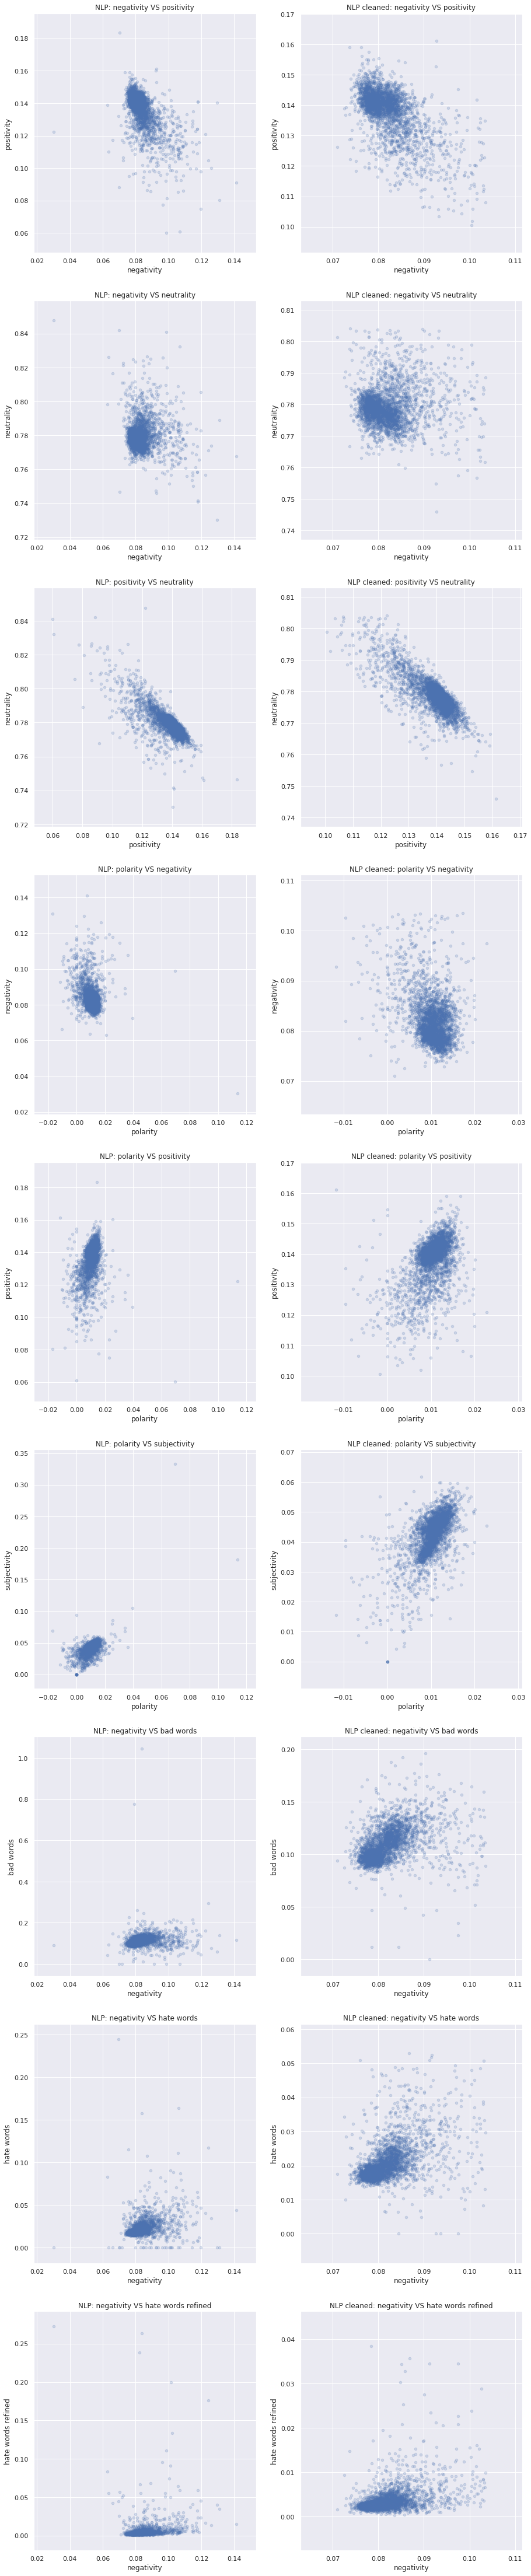

In [26]:
plot_nlp_metrics([nlp_n, nlp_n_cleaned], ['NLP', 'NLP cleaned'])